In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,UpSampling2D,Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
import numpy as np

import os
import random
import pickle
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(os.listdir("/content/gdrive/My Drive/covid-chestxray-dataset-master/covid-chestxray-dataset-master/data"))

['covid', 'non_covid']


In [ ]:
IMG_SIZE = 128

In [ ]:
CATEGORIES = ['cancer', 'normal']
dataset = []

def generate_data():
    for category in CATEGORIES:
        path = f'/content/gdrive/My Drive/breast-20200512T051500Z-001/breast_data/{category}'
        class_id = CATEGORIES.index(category)
        for image in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_COLOR)
                image_array = cv2.resize(image_array, (IMG_SIZE,IMG_SIZE))
                dataset.append([image_array, class_id])
            except Exception as e:
                print(e)
    random.shuffle(dataset)
                
generate_data()

In [ ]:
print(len(dataset))

178


In [ ]:
data = []
labels = []
for features, label in dataset:
    data.append(features)
    labels.append(label)

In [ ]:
import tensorflow as tf
data = np.array(data)
data.reshape(-1,128,3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
data = data/255
train_x,data,train_y,labels =train_test_split(data,labels,test_size=0.5)
test_data, validation_data, test_labels, validation_labels = train_test_split(data,labels,test_size=0.5)

In [ ]:
train_x = train_x/ 255
#train_x.resize(142,128,128,3)
#train_x.shape
#data.shape
data.shape
#validation_data.shape
#print(len(train_x))
#print(len())

(89, 128, 128, 3)

In [ ]:
input_layer=Input(shape= (128,128,3))

In [ ]:
#encoder part
encode_layer1 = Dense(1500, activation= 'relu')(input_layer)
encode_layer2 = Dense(1000, activation= 'relu')(encode_layer1)
encode_layer3 = Dense(500, activation= 'relu')(encode_layer2)
output_1 = Dense(3)(encode_layer3)
model1= Model(input_layer,output_1)
model1.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
dense_13 (Dense)             (None, 128, 128, 1500)    6000      
_________________________________________________________________
dense_14 (Dense)             (None, 128, 128, 1000)    1501000   
_________________________________________________________________
dense_15 (Dense)             (None, 128, 128, 500)     500500    
_________________________________________________________________
dense_16 (Dense)             (None, 128, 128, 3)       1503      
Total params: 2,009,003
Trainable params: 2,009,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = Sequential([
      
       Dense(3, activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)) ,
       Dense(16,activation='relu'),
       Dropout(0.2),
       Dense(32, activation='relu'),
       Dense(32, activation='sigmoid'),
       Dropout(0.5),
       Dense(3, activation='softmax')
])


In [ ]:
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model2.summary()
print(output_1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128, 128, 3)       12        
_________________________________________________________________
dense_18 (Dense)             (None, 128, 128, 16)      64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
dense_19 (Dense)             (None, 128, 128, 32)      544       
_________________________________________________________________
dense_20 (Dense)             (None, 128, 128, 32)      1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
dense_21 (Dense)             (None, 128, 128, 3)      

In [ ]:
from tensorflow.keras.layers import *
print(output_1.shape)
print(model2.output.shape)
merged = concatenate([output_1,model2.output])

(None, 128, 128, 3)
(None, 128, 128, 3)


In [ ]:
merged = Flatten()(merged)    
merged = Dense(256, activation='relu')(merged)
merged = Dropout(.5)(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dropout(.35)(merged)

# output layer
merged = Dense(5, activation='softmax')(merged)

In [ ]:
output = Dense(2, activation='softmax')(merged)

In [ ]:
newModel = Model([model1.input,model2.input],output)

In [ ]:
from keras.optimizers import SGD
opt = SGD(lr=0.01)
#newModel.compile(loss = "categorical_crossentropy", optimizer = opt)
#newModel.compile(optimizer=opt, loss='mse',metrics=['accuracy'])

newModel.compile(metrics=['accuracy'], loss='mse',optimizer ='Adam')
newModel.summary()
#early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')
#history1 = newModel.fit([train_x,data],train_y,batch_size=batch_size,epochs=epochs,verbose=1)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_17_input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 128, 128, 3)  12          dense_17_input[0][0]             
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 128, 128, 16) 64          dense_17[0][0]                   
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
_______________________________________________________________________________________

In [ ]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/gdrive/My Drive/chest_data_train_test_split/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = None)

test_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/chest_data_train_test_split/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = None)


Found 28 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [ ]:
pip install tensorflow

In [ ]:
epochs =30
#early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')
history1 = newModel.fit([train_x,data],y=np.array(train_y),batch_size=16,epochs=epochs,verbose=1,validation_split=0.1)
#history1 = newModel.fit([train_x,data],y=labels, batch_size=16,epochs=epochs,validation_split=0.1)

Epoch 1/30
5/5 [==============================] - 6s 1s/step - loss: 0.2642 - accuracy: 0.4375 - val_loss: 0.2512 - val_accuracy: 0.4444
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 0.2634 - accuracy: 0.5125 - val_loss: 0.2510 - val_accuracy: 0.4444
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 0.2566 - accuracy: 0.4625 - val_loss: 0.2507 - val_accuracy: 0.4444
Epoch 4/30
5/5 [==============================] - 5s 1s/step - loss: 0.2516 - accuracy: 0.4875 - val_loss: 0.2505 - val_accuracy: 0.4444
Epoch 5/30
5/5 [==============================] - 5s 1s/step - loss: 0.2509 - accuracy: 0.4875 - val_loss: 0.2504 - val_accuracy: 0.4444
Epoch 6/30
5/5 [==============================] - 5s 1s/step - loss: 0.2503 - accuracy: 0.5000 - val_loss: 0.2502 - val_accuracy: 0.4444
Epoch 7/30
5/5 [==============================] - 5s 1s/step - loss: 0.2510 - accuracy: 0.4875 - val_loss: 0.2501 - val_accuracy: 0.4444
Epoch 8/30
5/5 [=========================

In [ ]:
accuracy = history1.history['accuracy']
loss = history1.history['loss']
val_accuracy = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.6000000238418579
Training Loss: 0.25
Validation Accuracy: 0.5555555820465088
Validation Loss: 0.25


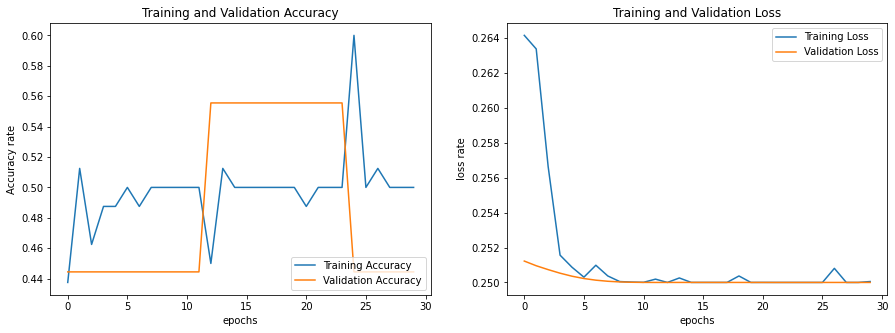

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xlabel('epochs')
plt.ylabel('Accuracy rate')
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel('epochs')
plt.ylabel('loss rate')
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
class_names = ['cancer', 'normal']
def plot_images(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i],images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]))

In [ ]:
#random.shuffle(test_data)

yPred = newModel.predict([test_data,test_data]).argmax( axis=-1 ) 
#yPred = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0]


In [ ]:
print(len(yPred))


44


In [ ]:
from sklearn.metrics import precision_score
print("Precision Score : ",precision_score(test_labels, yPred,
                                           average=None))

Precision Score :  [0.47368421 0.16666667]


In [ ]:
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

print('F1_score : ',f1_score(test_labels,yPred,average='micro'))
print('sensitibity : ',metrics.recall_score(test_labels, yPred,average='micro'))

F1_score :  0.4318181818181818
sensitibity :  0.4318181818181818


In [ ]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show() 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, yPred))

              precision    recall  f1-score   support

           0       0.47      0.78      0.59        23
           1       0.17      0.05      0.07        21

    accuracy                           0.43        44
   macro avg       0.32      0.42      0.33        44
weighted avg       0.33      0.43      0.34        44



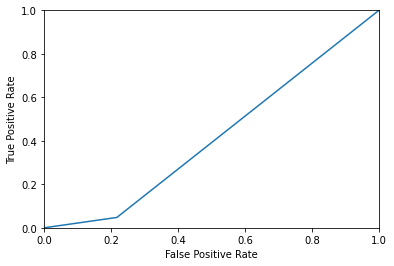

0.4151138716356108
-0.24710006719843874


In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

fpr , tpr , thresholds = roc_curve (test_labels,yPred)
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(test_labels,yPred) 
print(auc_score) 
print(matthews_corrcoef(test_labels,yPred))

In [ ]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show() 